In [1]:
################################################################################################################################
#
# LSTM - JANSEN - STANDARD - MONTHLY
#
################################################################################################################################

#-------------------------------------------------------------------------------------------------------------------------------
# 'Train RMSE: 4139.15 | Test RMSE: 6353.27'
#-------------------------------------------------------------------------------------------------------------------------------

#===============================================================================================================================
# ENVIRONMENT: LIBRARIES, SETTINGS
#===============================================================================================================================
#pip install pandas-datareader

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

from pathlib import Path

import numpy as np
import pandas as pd
import pandas_datareader.data as web
import sklearn
import sklearn.preprocessing
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import spearmanr

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Activation
from tensorflow import keras

In [2]:
#===============================================================================================================================
# ENVIRONMENT: HARDWARE
#===============================================================================================================================
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    print('Using GPU')
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
else:
    print('Using CPU')

Using CPU


In [3]:
#===============================================================================================================================
# ENVIRONMENT: CONFIG
#===============================================================================================================================
sns.set_style('whitegrid')
np.random.seed(42)

In [4]:
#===============================================================================================================================
# DATA: INPUT/OUTPUT
#===============================================================================================================================
input_path = Path('Data', 'Input')
results_path = Path('Data\Output', 'LSTM-Jansen-Standard-Monthly')
if not results_path.exists():
    results_path.mkdir(parents=True)

In [5]:
#===============================================================================================================================
# DATA: SETTINGS
#===============================================================================================================================
seriesId='IBOV-monthly'
#ESCALA = 'standard' 
#EPOCAS = 100
#LOTE = 12
#NEURONS = 32
window_size = 6 # 63

#===============================================================================================================================
# DATA: READ
#===============================================================================================================================
df = pd.read_csv(seriesId+'.csv')
df['Date']= pd.to_datetime(df['Date'], format='%d/%m/%Y')
df.set_index('Date', inplace=True)
df

,Close
Date,
2000-01-28,16734.39
2000-02-29,17660.20
2000-03-31,17820.37
2000-04-28,15537.60
2000-05-31,14956.61
...,...
2023-08-31,115741.81
2023-09-29,116565.17
2023-10-31,113143.67


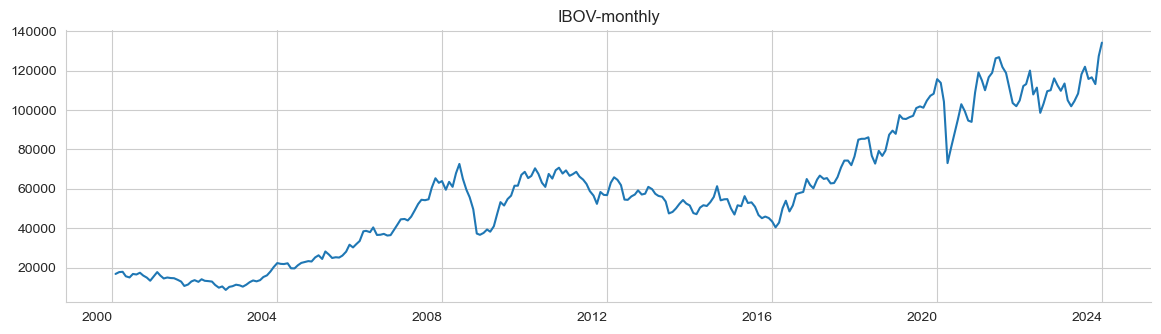

In [6]:
#===============================================================================================================================
# DATA: PLOT
#===============================================================================================================================
ax = df.plot(title=seriesId, legend=False, figsize=(14, 4), rot=0)
ax.set_xlabel('')
sns.despine()

In [7]:
#===============================================================================================================================
# DATA: SCALE - TRAIN
#===============================================================================================================================
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df_scaled = pd.Series(scaler.fit_transform(df[:'2022']).squeeze(), index=df[:'2022'].index)
df_scaled.describe()

count    2.760000e+02
mean     1.029772e-16
std      1.001817e+00
min     -1.541934e+00
25%     -8.007368e-01
50%     -3.387527e-02
75%      4.480417e-01
max      2.331562e+00
dtype: float64

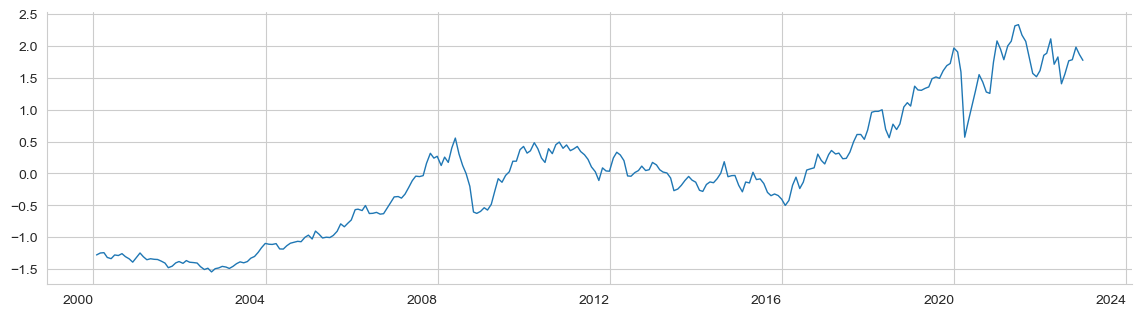

In [8]:
#===============================================================================================================================
# DATA: SCALE - TRAIN - PLOT
#===============================================================================================================================
ax = df_scaled.plot(lw=1, figsize=(14, 4), rot=0)
ax.set_xlabel('')
sns.despine()

In [9]:
#===============================================================================================================================
# DATA: SCALE - TEST
#===============================================================================================================================
df_scaledtest = pd.Series(scaler.transform(df['2022-07':]).squeeze(), index=df['2022-07':].index)
df_scaledtest

Date
2022-07-29    1.556826
2022-08-31    1.765225
2022-09-30    1.782069
2022-10-31    1.978737
2022-11-30    1.862346
2022-12-29    1.772164
2023-01-31    1.893304
2023-02-28    1.614749
2023-03-31    1.514790
2023-04-28    1.598351
2023-05-31    1.726292
2023-06-30    2.045926
2023-07-31    2.172312
2023-08-31    1.969059
2023-09-29    1.996046
2023-10-31    1.883901
2023-11-30    2.348916
2023-12-28    2.573570
dtype: float64

In [10]:
#===============================================================================================================================
# DATA: PREP - RECURRENT SEQUENCES - FUNCTION
#===============================================================================================================================
def create_univariate_rnn_data(data, window_size):
    n = len(data)
    y = data[window_size:]
    #y = data[window_size-1:]
    data = data.values.reshape(-1, 1) # make 2D
    X = np.hstack(tuple([data[i: n-j, :] for i, j in enumerate(range(window_size, 0, -1))]))
    #X = np.hstack(tuple([data[i: n-j+1, :] for i, j in enumerate(range(window_size, 0, -1))]))
    return pd.DataFrame(X, index=y.index), y

In [11]:
#===============================================================================================================================
# DATA: PREP - SEQUENCES - TRAIN
#===============================================================================================================================
X, y = create_univariate_rnn_data(df_scaled, window_size=window_size)
X


,0,1,2,3,4,5
Date,,,,,,
2000-07-31,-1.276056,-1.245711,-1.240461,-1.315282,-1.334325,-1.276267
2000-08-31,-1.245711,-1.240461,-1.315282,-1.334325,-1.276267,-1.285226
2000-09-29,-1.240461,-1.315282,-1.334325,-1.276267,-1.285226,-1.255986
2000-10-31,-1.315282,-1.334325,-1.276267,-1.285226,-1.255986,-1.302474
2000-11-30,-1.334325,-1.276267,-1.285226,-1.255986,-1.302474,-1.337255
...,...,...,...,...,...,...
2022-08-31,1.883845,2.108603,1.711251,1.825128,1.405308,1.556826
2022-09-30,2.108603,1.711251,1.825128,1.405308,1.556826,1.765225
2022-10-31,1.711251,1.825128,1.405308,1.556826,1.765225,1.782069


In [12]:
#===============================================================================================================================
# DATA: RESHAPE - TRAIN
#===============================================================================================================================
X_train = X[:'2022'].values.reshape(-1, window_size, 1)
y_train = y[:'2022']

In [13]:
#===============================================================================================================================
# DATA: PREP - SEQUENCES - TEST
#===============================================================================================================================
Xtest, ytest = create_univariate_rnn_data(df_scaledtest, window_size=window_size)
Xtest


,0,1,2,3,4,5
Date,,,,,,
2023-01-31,1.556826,1.765225,1.782069,1.978737,1.862346,1.772164
2023-02-28,1.765225,1.782069,1.978737,1.862346,1.772164,1.893304
2023-03-31,1.782069,1.978737,1.862346,1.772164,1.893304,1.614749
2023-04-28,1.978737,1.862346,1.772164,1.893304,1.614749,1.514790
2023-05-31,1.862346,1.772164,1.893304,1.614749,1.514790,1.598351
2023-06-30,1.772164,1.893304,1.614749,1.514790,1.598351,1.726292
2023-07-31,1.893304,1.614749,1.514790,1.598351,1.726292,2.045926
2023-08-31,1.614749,1.514790,1.598351,1.726292,2.045926,2.172312
2023-09-29,1.514790,1.598351,1.726292,2.045926,2.172312,1.969059


In [14]:
#===============================================================================================================================
# DATA: PREP - TEST
#===============================================================================================================================
X_test = Xtest['2023':].values.reshape(-1, window_size, 1)
y_test = ytest['2023':]

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
y_test

(270, 6, 1) (270,) (12, 6, 1) (12,)


Date
2023-01-31    1.893304
2023-02-28    1.614749
2023-03-31    1.514790
2023-04-28    1.598351
2023-05-31    1.726292
2023-06-30    2.045926
2023-07-31    2.172312
2023-08-31    1.969059
2023-09-29    1.996046
2023-10-31    1.883901
2023-11-30    2.348916
2023-12-28    2.573570
dtype: float64

In [15]:
#===============================================================================================================================
# DATA PREP: OBS, WINDOWS, FEATURES
#===============================================================================================================================
n_obs, window_size, n_features = X_train.shape
n_obs, window_size, n_features

(270, 6, 1)

In [16]:
#===============================================================================================================================
# MODEL: LSTM
#===============================================================================================================================
rnn = Sequential([
    LSTM(units=10, input_shape=(window_size, n_features), name='LSTM'),
    Dense(1, name='Output')
])

rnn.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 LSTM (LSTM)                 (None, 10)                480       
                                                                 
 Output (Dense)              (None, 1)                 11        
                                                                 
Total params: 491 (1.92 KB)
Trainable params: 491 (1.92 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [17]:
#===============================================================================================================================
# MODEL: CONFIG
#===============================================================================================================================
optimizer = keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9, epsilon=1e-08, weight_decay=0.0)

rnn.compile(loss='mean_squared_error', optimizer=optimizer)

rnn_path = (results_path / 'Standard-Monthly-rnn.h5').as_posix()
checkpointer = ModelCheckpoint(filepath=rnn_path, verbose=1, monitor='val_loss', save_best_only=True)

early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

In [18]:
#===============================================================================================================================
# MODEL: TRAIN
#===============================================================================================================================
lstm_training = rnn.fit(X_train, y_train, epochs=150, batch_size=12, shuffle=True, 
                        validation_data=(X_test, y_test), 
                        callbacks=[early_stopping, checkpointer],verbose=1)

Epoch 1/150

21/23 [==========================>...] - ETA: 0s - loss: 0.6087
Epoch 1: val_loss improved from inf to 2.36237, saving model to Data/Output/LSTM-Jansen-Standard-Monthly\Standard-Monthly-rnn.h5
23/23 [==============================] - 10s 100ms/step - loss: 0.6006 - val_loss: 2.3624
Epoch 2/150
17/23 [=====================>........] - ETA: 0s - loss: 0.4009
Epoch 2: val_loss improved from 2.36237 to 1.60994, saving model to Data/Output/LSTM-Jansen-Standard-Monthly\Standard-Monthly-rnn.h5
23/23 [==============================] - 0s 11ms/step - loss: 0.4170 - val_loss: 1.6099
Epoch 3/150
18/23 [======================>.......] - ETA: 0s - loss: 0.3061
Epoch 3: val_loss improved from 1.60994 to 1.11436, saving model to Data/Output/LSTM-Jansen-Standard-Monthly\Standard-Monthly-rnn.h5
23/23 [==============================] - 0s 12ms/step - loss: 0.2786 - val_loss: 1.1144
Epoch 4/150
19/23 [=======================>......] - ETA: 0s - loss: 0.1803
Epoch 4: val_loss improved from 1.

23/23 [==============================] - 0s 8ms/step - loss: 0.0300 - val_loss: 0.0864
Epoch 32/150
12/23 [==============>...............] - ETA: 0s - loss: 0.0300
Epoch 32: val_loss improved from 0.07903 to 0.07074, saving model to Data/Output/LSTM-Jansen-Standard-Monthly\Standard-Monthly-rnn.h5
23/23 [==============================] - 0s 9ms/step - loss: 0.0291 - val_loss: 0.0707
Epoch 33/150
19/23 [=======================>......] - ETA: 0s - loss: 0.0318
Epoch 33: val_loss did not improve from 0.07074
23/23 [==============================] - 0s 9ms/step - loss: 0.0291 - val_loss: 0.0808
Epoch 34/150
23/23 [==============================] - ETA: 0s - loss: 0.0285
Epoch 34: val_loss did not improve from 0.07074
23/23 [==============================] - 0s 8ms/step - loss: 0.0285 - val_loss: 0.0813
Epoch 35/150
19/23 [=======================>......] - ETA: 0s - loss: 0.0216
Epoch 35: val_loss did not improve from 0.07074
23/23 [==============================] - 0s 9ms/step - loss: 0.028

22/23 [===========================>..] - ETA: 0s - loss: 0.0207
Epoch 67: val_loss improved from 0.05667 to 0.05288, saving model to Data/Output/LSTM-Jansen-Standard-Monthly\Standard-Monthly-rnn.h5
23/23 [==============================] - 0s 9ms/step - loss: 0.0205 - val_loss: 0.0529
Epoch 68/150
19/23 [=======================>......] - ETA: 0s - loss: 0.0217
Epoch 68: val_loss did not improve from 0.05288
23/23 [==============================] - 0s 9ms/step - loss: 0.0213 - val_loss: 0.0579
Epoch 69/150
22/23 [===========================>..] - ETA: 0s - loss: 0.0210
Epoch 69: val_loss did not improve from 0.05288
23/23 [==============================] - 0s 9ms/step - loss: 0.0206 - val_loss: 0.0559
Epoch 70/150
21/23 [==========================>...] - ETA: 0s - loss: 0.0212
Epoch 70: val_loss did not improve from 0.05288
23/23 [==============================] - 0s 10ms/step - loss: 0.0206 - val_loss: 0.0571
Epoch 71/150
22/23 [===========================>..] - ETA: 0s - loss: 0.0205
E

23/23 [==============================] - 0s 7ms/step - loss: 0.0179 - val_loss: 0.0565
Epoch 105/150
21/23 [==========================>...] - ETA: 0s - loss: 0.0183
Epoch 105: val_loss did not improve from 0.04617
23/23 [==============================] - 0s 9ms/step - loss: 0.0179 - val_loss: 0.0483


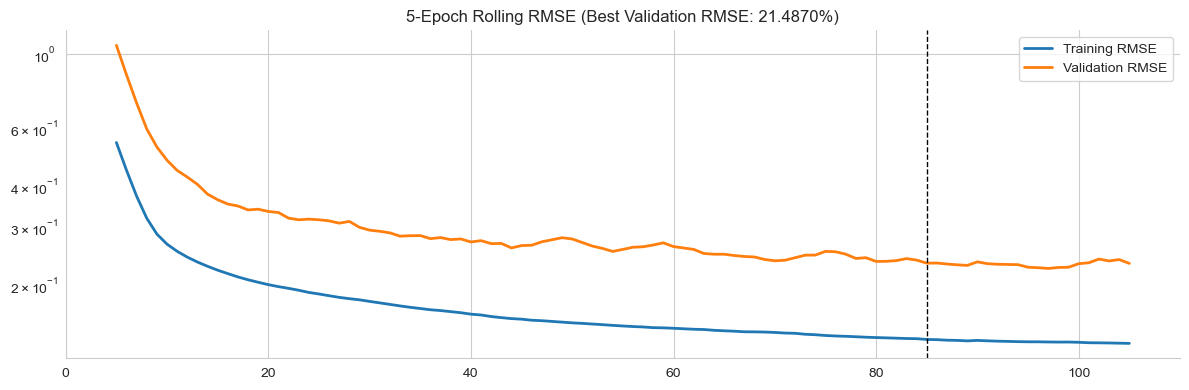

In [19]:
#===============================================================================================================================
# RESULTS - PERFORMANCE vs EPOCHS - TRAIN, VALIDATION
#===============================================================================================================================
fig, ax = plt.subplots(figsize=(12, 4))

loss_history = pd.DataFrame(lstm_training.history).pow(.5)
loss_history.index += 1
best_rmse = loss_history.val_loss.min()

best_epoch = loss_history.val_loss.idxmin()

title = f'5-Epoch Rolling RMSE (Best Validation RMSE: {best_rmse:.4%})'
loss_history.columns=['Training RMSE', 'Validation RMSE']
loss_history.rolling(5).mean().plot(logy=True, lw=2, title=title, ax=ax)

ax.axvline(best_epoch, ls='--', lw=1, c='k')

sns.despine()
fig.tight_layout()
fig.savefig(results_path / 'rnn_error', dpi=300);

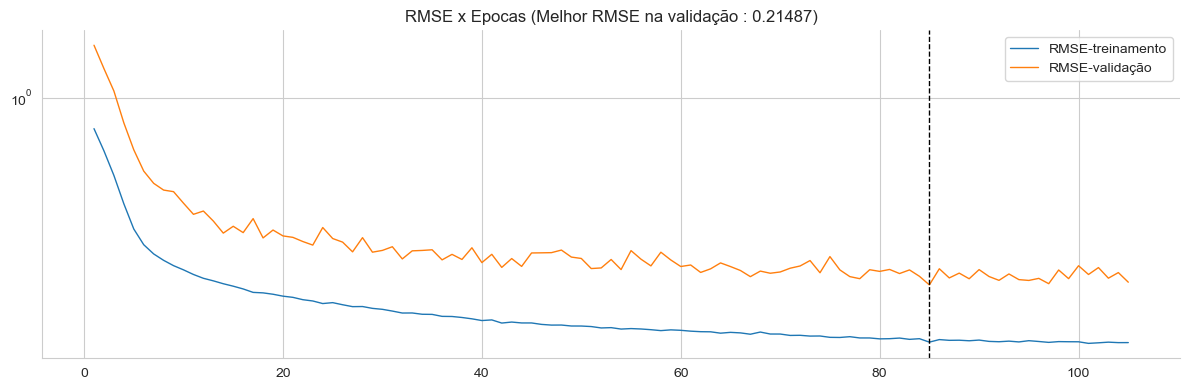

In [20]:
#===============================================================================================================================
# RESULTS - PERFORMANCE vs EPOCHS - TRAIN, VALIDATION
#===============================================================================================================================
fig, ax = plt.subplots(figsize=(12, 4))

loss_history = pd.DataFrame(lstm_training.history).pow(.5)
loss_history.index += 1
best_rmse = loss_history.val_loss.min()

best_epoch = loss_history.val_loss.idxmin()

title = f'RMSE x Epocas (Melhor RMSE na validação : {best_rmse:.6})'
loss_history.columns=['RMSE-treinamento', 'RMSE-validação']
loss_history.rolling(1).mean().plot(logy=True, lw=1, title=title, ax=ax)

ax.axvline(best_epoch, ls='--', lw=1, c='k')

sns.despine()
fig.tight_layout()
fig.savefig(results_path / 'rnn_error', dpi=300);

In [21]:
#===============================================================================================================================
# RESULTS - PERFORMANCE - TRAIN, TEST
#===============================================================================================================================
train_rmse_scaled = np.sqrt(rnn.evaluate(X_train, y_train, verbose=0))
test_rmse_scaled = np.sqrt(rnn.evaluate(X_test, y_test, verbose=0))
print(f'Train RMSE: {train_rmse_scaled:.4f} | Test RMSE: {test_rmse_scaled:.4f}')
#-------------------------------------------------------------------------------------------------------------------------------
# Train RMSE: 0.1357 | Test RMSE: 0.2082
#-------------------------------------------------------------------------------------------------------------------------------

Train RMSE: 0.1430 | Test RMSE: 0.2149


In [22]:
#===============================================================================================================================
# RESULTS - FORECAST - TRAIN, TEST
#===============================================================================================================================
train_predict_scaled = rnn.predict(X_train)
test_predict_scaled = rnn.predict(X_test)

1/1 [==============================] - 0s 47ms/step


In [23]:
#===============================================================================================================================
# RESULTS - SPEARMAN IC - TRAIN, TEST
#===============================================================================================================================
train_ic = spearmanr(y_train, train_predict_scaled)[0]
test_ic = spearmanr(y_test, test_predict_scaled)[0]
print(f'Train IC: {train_ic:.6f} | Test IC: {test_ic:.4f}')
#-------------------------------------------------------------------------------------------------------------------------------
# Train IC: 0.988022 | Test IC: 0.6503
#-------------------------------------------------------------------------------------------------------------------------------

Train IC: 0.987493 | Test IC: 0.6224


In [24]:
#===============================================================================================================================
# RESULTS - FORECAST - RESULTS
#===============================================================================================================================
test_predict_scaled[:,0]

array([1.8515489, 1.9451014, 1.7399642, 1.6721965, 1.7367102, 1.8250623,
       2.037745 , 2.1067195, 1.9747611, 2.0080247, 1.9360656, 2.2348301],
      dtype=float32)

In [25]:
#===============================================================================================================================
# RESULTS - SCALED - PRED - EXPORT
#===============================================================================================================================
#dftest_predict_scaled=test_predict_scaled.to_frame()
#dftest_predict_scaled.to_excel('Data/Output/LSTM-Jansen-Monthly-Scaled-Train.xlsx')
#dftest_predict_scaled
#test_predict_scaled.to_excel('Data/Output/LSTM-Jansen-Monthly-Scaled-Train.xlsx')
np.savetxt('Data/Output/LSTM-Jansen-Standard-Monthly-Scaled-Train.txt', train_predict_scaled, delimiter=';')
np.savetxt('Data/Output/LSTM-Jansen-Standard-Monthly-Scaled-Test.txt' , test_predict_scaled , delimiter=';')


In [26]:
#===============================================================================================================================
# RESULTS - PRICE - RECOVER - PRED - TRAIN, TEST
#===============================================================================================================================
train_predict = pd.Series(scaler.inverse_transform(train_predict_scaled).squeeze(), index=y_train.index)
test_predict  = pd.Series(scaler.inverse_transform(test_predict_scaled).squeeze() , index=y_test.index )

test_predict

Date
2023-01-31    112156.601562
2023-02-28    115010.859375
2023-03-31    108752.195312
2023-04-28    106684.617188
2023-05-31    108652.914062
2023-06-30    111348.507812
2023-07-31    117837.390625
2023-08-31    119941.781250
2023-09-29    115915.773438
2023-10-31    116930.632812
2023-11-30    114735.179688
2023-12-28    123850.390625
dtype: float32

In [27]:
#===============================================================================================================================
# RESULTS - PRICE - PRED - EXPORT
#===============================================================================================================================
dftest_predict=test_predict.to_frame()
dftest_predict


,0
Date,
2023-01-31,112156.601562
2023-02-28,115010.859375
2023-03-31,108752.195312
2023-04-28,106684.617188
2023-05-31,108652.914062
2023-06-30,111348.507812
2023-07-31,117837.390625
2023-08-31,119941.781250
2023-09-29,115915.773438


In [28]:
#===============================================================================================================================
# RESULTS - PRICE - RECOVER - TARGET - TRAIN, TEST
#===============================================================================================================================
y_train_rescaled = scaler.inverse_transform(y_train.to_frame()).squeeze()
y_test_rescaled = scaler.inverse_transform(y_test.to_frame()).squeeze()

y_test_rescaled

array([113430.54, 104931.93, 101882.2 , 104431.63, 108335.07, 118087.  ,
       121942.98, 115741.81, 116565.17, 113143.67, 127331.12, 134185.24])

In [29]:
#===============================================================================================================================
# RESULTS - PRICE - PERFORMANCE - TRAIN, TEST
#===============================================================================================================================
train_rmse = np.sqrt(mean_squared_error(train_predict, y_train_rescaled))
test_rmse = np.sqrt(mean_squared_error(test_predict, y_test_rescaled))
f'Train RMSE: {train_rmse:.2f} | Test RMSE: {test_rmse:.2f}'
#-------------------------------------------------------------------------------------------------------------------------------
# 'Train RMSE: 4139.15 | Test RMSE: 6353.27'
#-------------------------------------------------------------------------------------------------------------------------------

'Train RMSE: 4364.26 | Test RMSE: 6555.62'

In [30]:
#===============================================================================================================================
# RESULTS - PRICE - STORE - TRAIN, TEST
#===============================================================================================================================
df['Train Predictions'] = train_predict
df['Test Predictions'] = test_predict

temp = pd.concat([train_predict.to_frame('predictions').assign(data='Train'), test_predict.to_frame('predictions').assign(data='Test')])
df['predictions'] = temp['predictions']
df['data']        = temp['data']

df['2022-12-29':]

,Close,Train Predictions,Test Predictions,predictions,data
Date,,,,,
2022-12-29,109734.60,113790.414062,NaN,113790.414062,Train
2023-01-31,113430.54,NaN,112156.601562,112156.601562,Test
2023-02-28,104931.93,NaN,115010.859375,115010.859375,Test
2023-03-31,101882.20,NaN,108752.195312,108752.195312,Test
2023-04-28,104431.63,NaN,106684.617188,106684.617188,Test
2023-05-31,108335.07,NaN,108652.914062,108652.914062,Test
2023-06-30,118087.00,NaN,111348.507812,111348.507812,Test
2023-07-31,121942.98,NaN,117837.390625,117837.390625,Test
2023-08-31,115741.81,NaN,119941.781250,119941.781250,Test


In [31]:
#===============================================================================================================================
# RESULTS - PRICE - EXPORT
#===============================================================================================================================
df.to_excel('Data/Output/LSTM-Jansen-Standard-Monthly.xlsx')

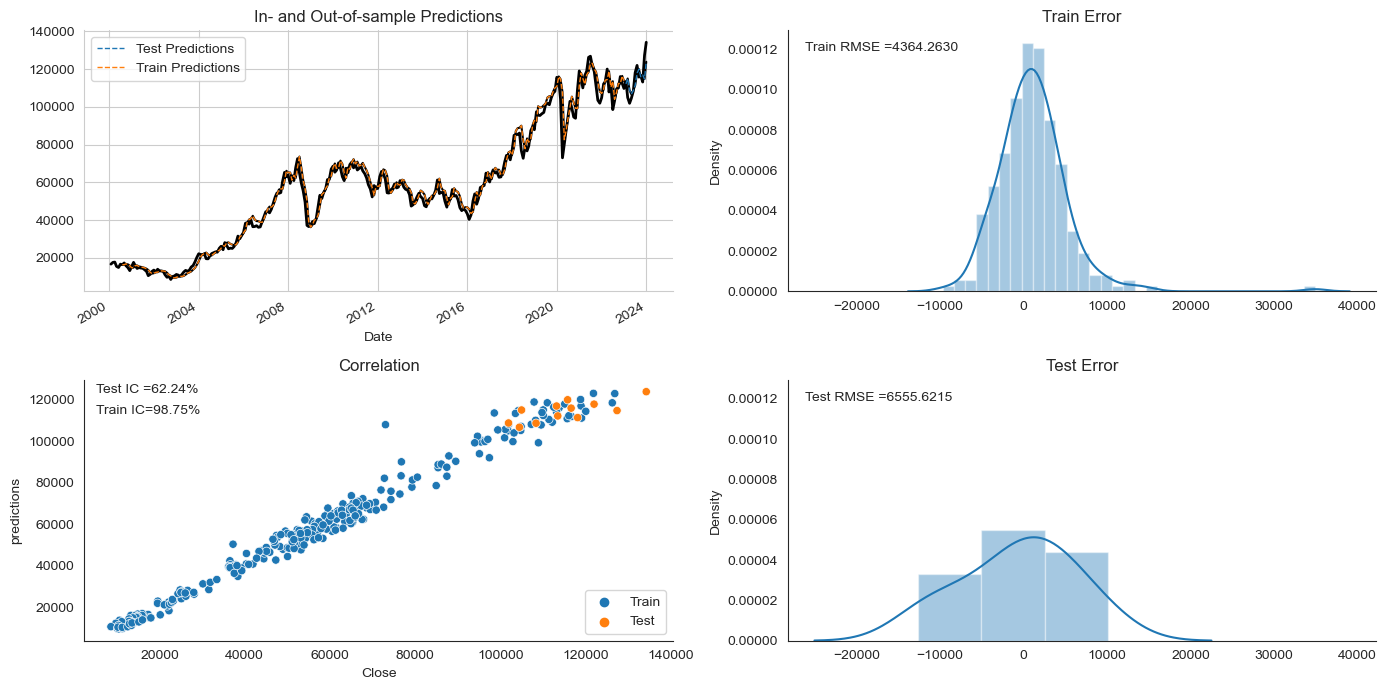

In [32]:
#===============================================================================================================================
# RESULTS - PRICE - PLOT
#===============================================================================================================================

fig=plt.figure(figsize=(14,7))
ax1 = plt.subplot(221)

df.loc['2000':, 'Close'].plot(lw=2, ax=ax1, c='k')
df.loc['2000':, 'predictions'].plot(lw=1.5, ax=ax1, c='k')
df.loc['2000':, ['Test Predictions', 'Train Predictions']].plot(lw=1, ax=ax1, ls='--')
ax1.set_title('In- and Out-of-sample Predictions')

with sns.axes_style("white"):
    ax3 = plt.subplot(223)
    sns.scatterplot(x='Close', y='predictions', data=df, hue='data', ax=ax3)
    ax3.text(x=.02, y=.95, s=f'Test IC ={test_ic:.2%}', transform=ax3.transAxes)
    ax3.text(x=.02, y=.87, s=f'Train IC={train_ic:.2%}', transform=ax3.transAxes)
    ax3.set_title('Correlation')
    ax3.legend(loc='lower right')
    
    ax2 = plt.subplot(222)
    ax4 = plt.subplot(224, sharex = ax2, sharey=ax2)
    sns.distplot(train_predict.squeeze()- y_train_rescaled, ax=ax2)
    ax2.set_title('Train Error')
    ax2.text(x=.03, y=.92, s=f'Train RMSE ={train_rmse:.4f}', transform=ax2.transAxes)
    sns.distplot(test_predict.squeeze()-y_test_rescaled, ax=ax4)
    ax4.set_title('Test Error')
    ax4.text(x=.03, y=.92, s=f'Test RMSE ={test_rmse:.4f}', transform=ax4.transAxes)

sns.despine()
fig.tight_layout()
fig.savefig(results_path / 'rnn_regression', dpi=300);
